<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import Nets
from Nets import*

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

In [2]:
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)])
pregame.reset(set_agent=(2,2))
# rls_q = RLS(1)
# rls_sl = RLS(1)
# for i in range(1):
#     pregame.fulltrain(trials = 4)
    

In [3]:
game = ValueMaxGame(pregame.net, grid_size = (15, 15), holes = 50, random_seed = 4 , set_reward =  [(0.5, 0.25), (0.5, 0.75)])
# game.experiment(rls_q, rls_sl, 20, epsilon = 0.5, lr = 1e-3, train_hidden = False, train_q = False) 

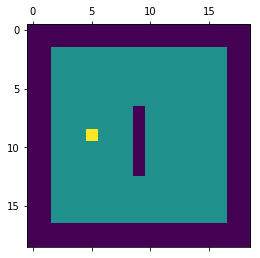

In [4]:
game.reset(size = 15, reward_control=0)
plt.matshow(game.grid.grid)

# plt.savefig('g16h3-map')

Think of how to make this traning stable, adding exploration noise , intenral noise or environmental variability like multiple mazes  

In [5]:
# moving bar train
for iters, noise in enumerate(3 * [0.0]):
    for trial in [0]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix3/weights3/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train =[15], size_test=[15])
        np.save('Rewards_{}_{}.npy'.format(iters, trial), rewards)

clear session data 4 13286539264
0 rewards -0.453125
clear session data 4 13556736000
1 rewards -0.328125
clear session data 4 13557260288
2 rewards -0.235703125
clear session data 4 13556740096
3 rewards -0.23585792824074076
clear session data 4 13556740096
4 rewards -0.17220315662955465
clear session data 4 13557002240
5 rewards -0.15645926339285715
clear session data 4 13556744192
6 rewards 0.014075969827586188
clear session data 4 13557006336
7 rewards -0.0322265625
clear session data 4 13557268480
8 rewards 0.07736073369565218
clear session data 4 13557010432
9 rewards 0.18341056034482758
clear session data 4 13557272576
10 rewards 0.09076450892857142
clear session data 4 13557534720
11 rewards 0.295654296875
clear session data 4 13557272576
12 rewards 0.23159947997541408
clear session data 4 13557276672
13 rewards 0.32505936701787996
clear session data 4 13557538816
14 rewards 0.2932582288401254
clear session data 4 13557014528
15 rewards 0.3415212943193582
clear session data 4 1

In [ ]:
# moving bar train, with strengthened action 
for iters, noise in enumerate(3 * [0.0]):
    for trial in [0]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix4/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train =[15], size_test=[15],\
                                k_action = 5)


clear session data 4 13211820032
0 rewards -0.3766282894736842
clear session data 4 13658816512
1 rewards -0.2529658564814815
clear session data 4 13598130176
2 rewards -0.2073426085633117
clear session data 4 13659201536
3 rewards -0.2975260416666667
clear session data 4 13597319168
4 rewards -0.29725060096153844
clear session data 4 13659512832
5 rewards -0.2041015625
clear session data 4 13597360128
6 rewards -0.12698102678571427
clear session data 4 13659766784
7 rewards -0.20414663461538463
clear session data 4 13668818944
8 rewards -0.203125
clear session data 4 13730172928
9 rewards -0.23514441287878787
clear session data 4 13668278272
10 rewards -0.0029875578703703887
clear session data 4 13729898496
11 rewards -0.2665318080357143
clear session data 4 13668536320
12 rewards -0.11639782656081148
clear session data 4 13649719296
13 rewards -0.21875
clear session data 4 13587828736
14 rewards -0.3154494160353535
clear session data 4 13649379328
15 rewards -0.026274958069080534
cle

In [ ]:
# moving bar train, with strengthened action 
for iters, noise in enumerate(3 * [0.0]):
    for trial in [0]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights_fix4/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters+1)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 50, noise = noise, size_train =[15], size_test=[15],\
                                k_action = 5)


clear session data 4 13462134784
0 rewards -0.34556107954545456
clear session data 4 13598126080
1 rewards -0.207175898731203
clear session data 4 13659889664
2 rewards -0.3930338541666667
clear session data 4 13748297728
3 rewards -0.328125
clear session data 4 13748412416
4 rewards -0.2853348637040043
clear session data 4 13748137984
5 rewards -0.3491123803135522
clear session data 4 13748932608
6 rewards -0.23682288212864722
clear session data 4 13748916224
7 rewards -0.33501953125
clear session data 4 13748645888
8 rewards -0.19360668628246752
clear session data 4 13748633600
9 rewards -0.2840606007623894
clear session data 4 13748903936
10 rewards -0.2672526041666667
clear session data 4 13748625408
11 rewards -0.15970268338432403
clear session data 4 13749145600
12 rewards -0.27008688038793105
clear session data 4 13748867072
13 rewards -0.3349381738053613
clear session data 4 13748604928
14 rewards -0.2824497767857143
clear session data 4 13748871168
15 rewards -0.265625
clear s

### measure decoding 

Decoding accuracy decreases, there are two possible reasons: 
1, decoding has bias,  information of position is only refleted by decoding, if there is certain bias , it is not trustable
2, it is the real measure of information, so there are less spatial information about space, or an effect decoupling/disentanglement of position. This can be due the network succeed at finding an even lower diemnsion object which gives successful performance.  The representation deceases its information to input in a sense. 

This can be linked to receptive field by looking at how space is represented. 